In [1]:
from Run import Run
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
# study timing properties of east area beam (and other timings)
# - because there is no master clock tied to RF, accurate timing between buckets can only be determined
#   using events that capture two populated buckets
# - evaluate the mean separation between buckets and the time distribution within a bucket

folder = "C:/Users/Karlen/Documents/temp/wtime/"

# run 464: no electron veto:
run_number = 464
#run_number = 745
run = Run.open_file(folder+"run_000"+str(run_number)+".dk")
config = run.config

if 'signal_times' in run.user:
    signal_times = run.user['signal_times']
else:
    signal_times = None

In [3]:
# For fitting:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))/np.sqrt(2.*np.pi)/sigma

def gauss_back(x, *p):
    A, mu, sigma, A2 = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))/np.sqrt(2.*np.pi)/sigma+A2

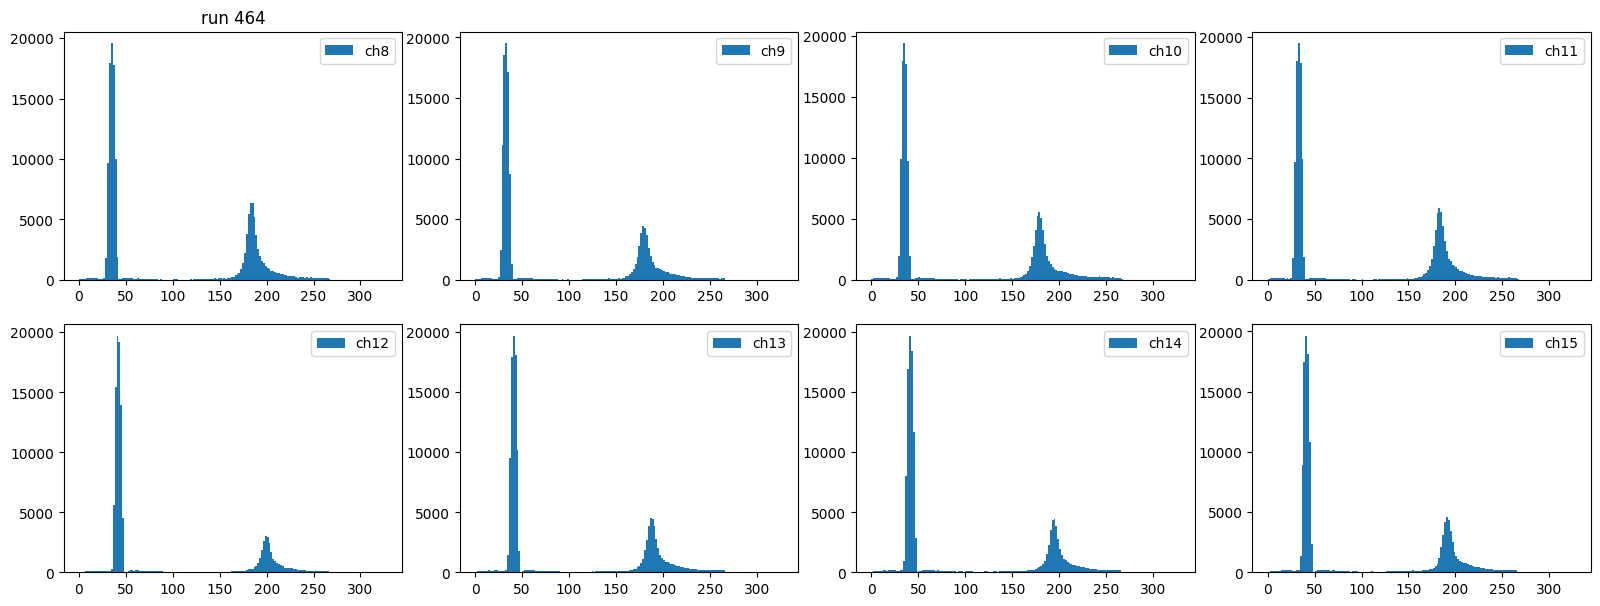

In [4]:
# Look at signal_time distributions for each scintillator channel

channels = range(8,16)

fig, axss = plt.subplots(2, 4, figsize=(16, 6))
fig.tight_layout()

axss[0][0].set_title("run " + str(run_number))

for ic, c in enumerate(channels):
    axis = axss[int(ic/4)][ic%4]
    sts = []
    for event in signal_times[c]:
        for st in event:
            sts.append(st)
    axis.hist(sts,bins=np.arange(0,330,2),label='ch'+str(c))
    #axis.hist(sts,bins=np.arange(160,200,0.5),label='ch'+str(c))
    #axis.hist(sts,bins=np.arange(25,45,0.2),label='ch'+str(c))
    axis.legend()
#plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
plt.show()

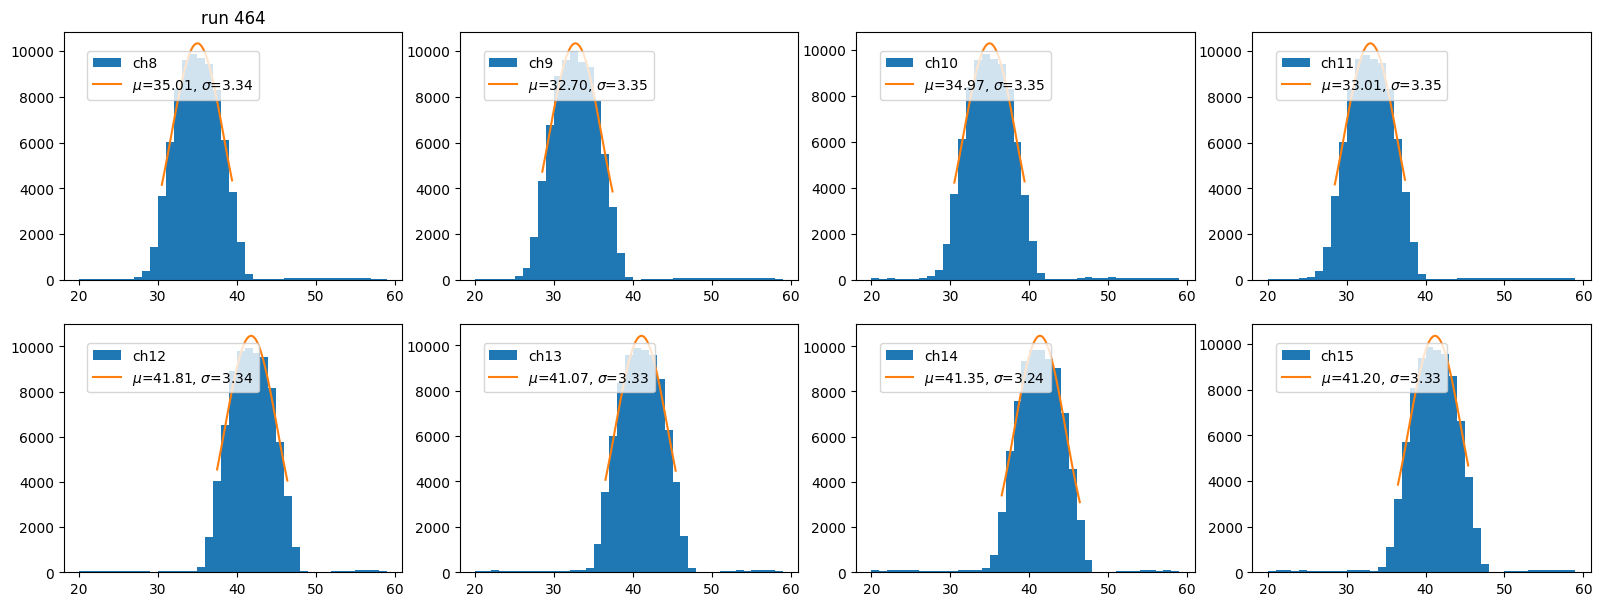

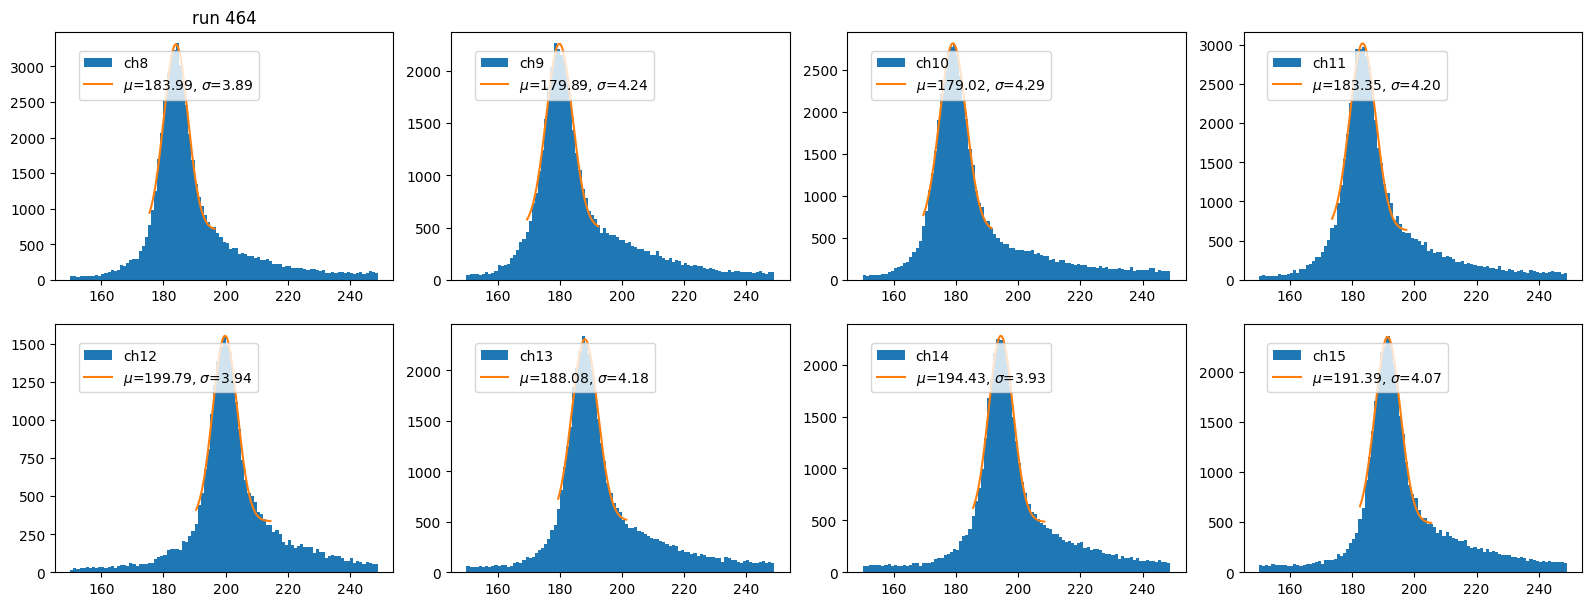

In [5]:
# Look at signal_time distributions for each scintillator channel

channels = range(8,16)

for st_range in [[20,60],[150,250]]:
    fig, axss = plt.subplots(2, 4, figsize=(16, 6))
    fig.tight_layout()

    axss[0][0].set_title("run " + str(run_number))

    for ic, c in enumerate(channels):
        axis = axss[int(ic/4)][ic%4]
        sts = []
        for event in signal_times[c]:
            for st in event:
                sts.append(st)

        # fit to a Gaussian
        bin_width = 1
        bins = np.arange(st_range[0],st_range[1],bin_width)
        hist, bin_edges = np.histogram(sts, bins=bins)
        max_num = np.max(hist)
        low = -1
        high = -1
        for ib, num in enumerate(hist):
            if low < 0 and num > 0.2*max_num:
                low = ib
            if low > 0 and num < 0.2*max_num:
                high = ib
                break

        fit_hist = [hist[i] for i in range(low,high)]
        bin_centres = [bins[i]+bin_width/2. for i in range(low,high)]

        total = 0.
        sum = 0.
        sum2 = 0.
        for num,bc in zip(fit_hist, bin_centres):
            total+= num
            sum += num*bc
            sum2 += num*bc*bc
        mean = sum/total
        var = sum2/total - mean*mean
        std = np.sqrt(var)

        if st_range[0] == 20:
            # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
            p0 = [total*bin_width, mean, std]

            coeff, var_matrix = curve_fit(gauss, bin_centres, fit_hist, p0=p0)

            # Get the fitted curve
            fine_bins = np.arange(bin_centres[0],bin_centres[-1],bin_width/10)
            hist_fit = gauss(fine_bins, *coeff)
        else:
            p0 = [total*bin_width, mean, std, 100.]

            coeff, var_matrix = curve_fit(gauss_back, bin_centres, fit_hist, p0=p0)

            # Get the fitted curve
            fine_bins = np.arange(bin_centres[0],bin_centres[-1],bin_width/10)
            hist_fit = gauss_back(fine_bins, *coeff)

        axis.hist(sts,bins=bins,label='ch'+str(c))
        #axis.hist(sts,bins=np.arange(160,200,0.5),label='ch'+str(c))
        #axis.hist(sts,bins=np.arange(25,45,0.2),label='ch'+str(c))
        axis.plot(fine_bins,hist_fit,label=f"$\mu$={coeff[1]:.2f}, $\sigma$={coeff[2]:.2f}")
        axis.legend(loc='upper left', bbox_to_anchor=(0.05,0.95))
    #plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
    plt.show()

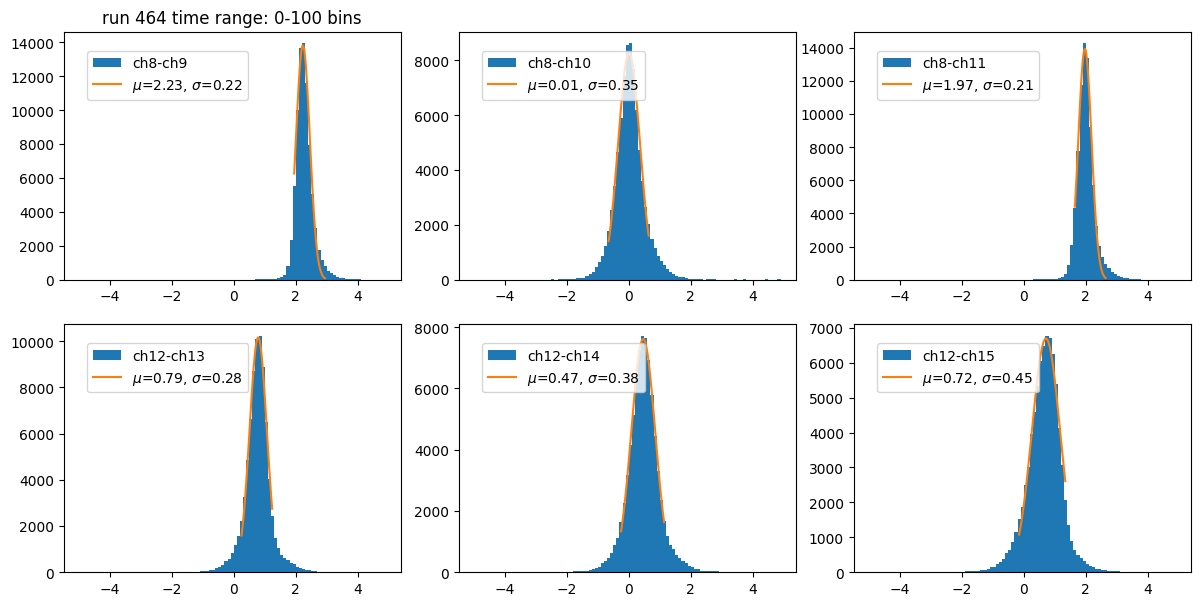

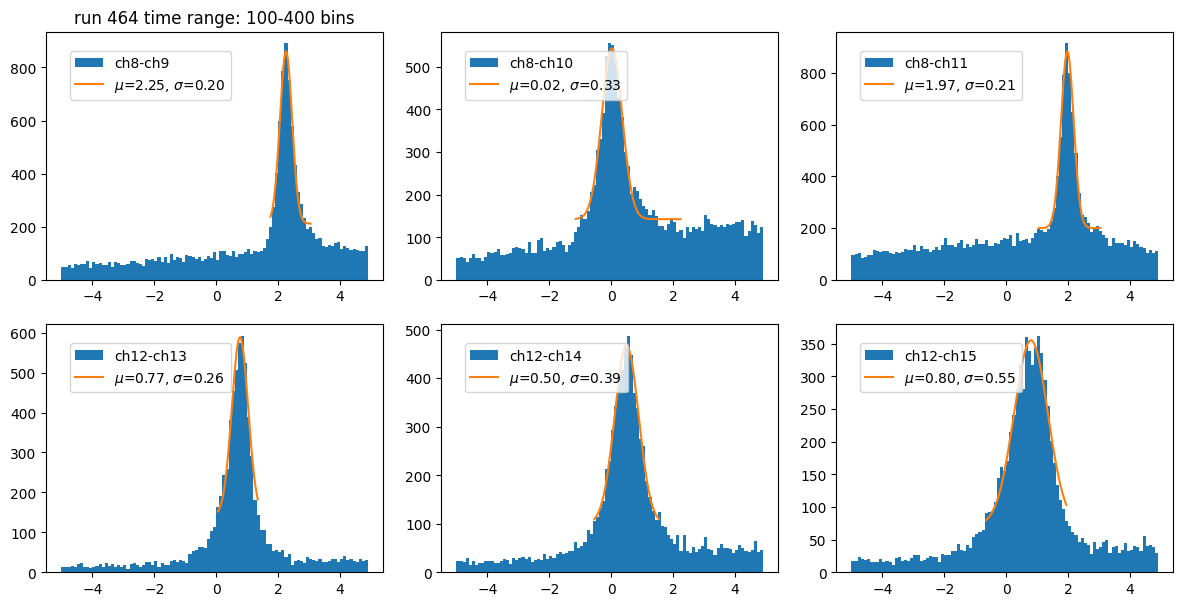

In [107]:
# Look at signal_time difference distributions for each scintillator channel wrt first channel

delta_t_mean = {}
delta_t_sigma = {}

for st_range in [[0,100],[100,400]]:

    fig, axss = plt.subplots(2, 3, figsize=(12, 6))
    fig.tight_layout()

    axss[0][0].set_title("run " + str(run_number) + " time range: "+str(st_range[0])+"-"+str(st_range[1])+" bins")

    for it in range(2):
        first_chan = it*4 + 8
        for other_chan in range(3):
            axis = axss[it][other_chan]
            diffs = []
            for ie, event in enumerate(signal_times[first_chan]):
                if len(event) > 0:
                    for first_chan_st in event:
                        if st_range[0] < first_chan_st < st_range[1]:
                            for other_st in signal_times[first_chan+other_chan+1][ie]:
                                if st_range[0] < other_st < st_range[1]:
                                    diff = first_chan_st - other_st
                                    diffs.append(diff)

            # fit to a Gaussian
            bins = np.arange(-5.,5.,0.1)
            hist, bin_edges = np.histogram(diffs, bins=bins)
            max_num = np.max(hist)
            low = -1
            high = -1
            for ib, num in enumerate(hist):
                if low < 0 and num > 0.2*max_num:
                    low = ib
                if low > 0 and num < 0.2*max_num and ib > low + 10:
                    high = ib
                    break

            fit_hist = [hist[i] for i in range(low,high)]
            bin_centres = [bins[i]+0.05 for i in range(low,high)]

            total = 0.
            sum = 0.
            sum2 = 0.
            for num,bc in zip(fit_hist, bin_centres):
                total+= num
                sum += num*bc
                sum2 += num*bc*bc
            if total > 0:
                mean = sum/total
                var = sum2/total - mean*mean
                std = np.sqrt(var)
            else:
                mean = 0.
                std = 0.

            #print(first_chan,other_chan,total,mean,std)

            if st_range[0] == 0:
                # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                p0 = [total*0.1, mean, std]

                coeff, var_matrix = curve_fit(gauss, bin_centres, fit_hist, p0=p0)

                # save fit values
                if first_chan not in delta_t_mean:
                    delta_t_mean[first_chan]={}
                    delta_t_sigma[first_chan]={}
                delta_t_mean[first_chan][first_chan+other_chan+1] = coeff[1]
                delta_t_sigma[first_chan][first_chan+other_chan+1] = coeff[2]

                # Get the fitted curve
                fine_bins = np.arange(bin_centres[0],bin_centres[-1],0.01)
                hist_fit = gauss(fine_bins, *coeff)
            else:
                p0 = [total*0.1, mean, std, 100.]

                coeff, var_matrix = curve_fit(gauss_back, bin_centres, fit_hist, p0=p0)

                # Get the fitted curve
                fine_bins = np.arange(bin_centres[0],bin_centres[-1],0.01)
                hist_fit = gauss_back(fine_bins, *coeff)

            #axis.hist(diffs,bins=np.arange(0,330,2),label='ch'+str(c))
            axis.hist(diffs,bins=np.arange(-5.,5.,0.1),label='ch'+str(first_chan)+'-'+'ch'+str(first_chan+other_chan+1))
            axis.plot(fine_bins,hist_fit,label=f"$\mu$={coeff[1]:.2f}, $\sigma$={coeff[2]:.2f}")
            axis.legend(loc='upper left', bbox_to_anchor=(0.05,0.95))
    #plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
    plt.show()

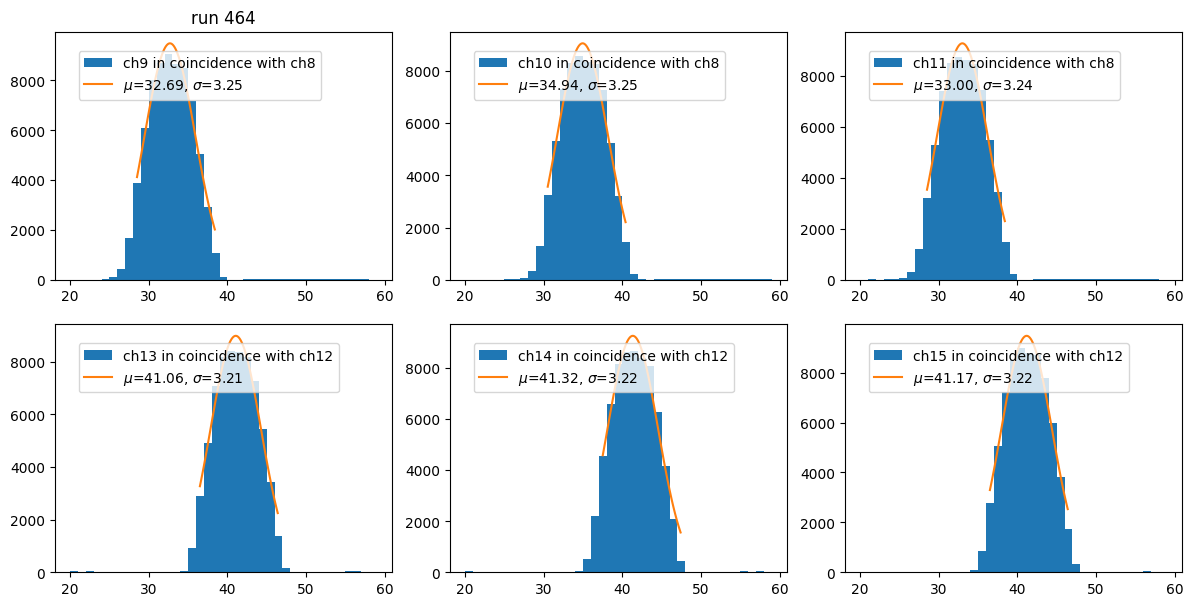

89 channel 13, mean = 207.5, std = 20.1  
89 channel 10, mean = 202.3, std = 20.1  
1213 channel 10, mean = 202.1, std = 20.2  
89 channel 14, mean = 207.3, std = 20.2  
1213 channel 14, mean = 207.9, std = 20.5  
89 channel 11, mean = 200.5, std = 20.4  
1213 channel 11, mean = 200.1, std = 20.3  
89 channel 15, mean = 207.1, std = 20.2  
1213 channel 15, mean = 207.5, std = 20.6  


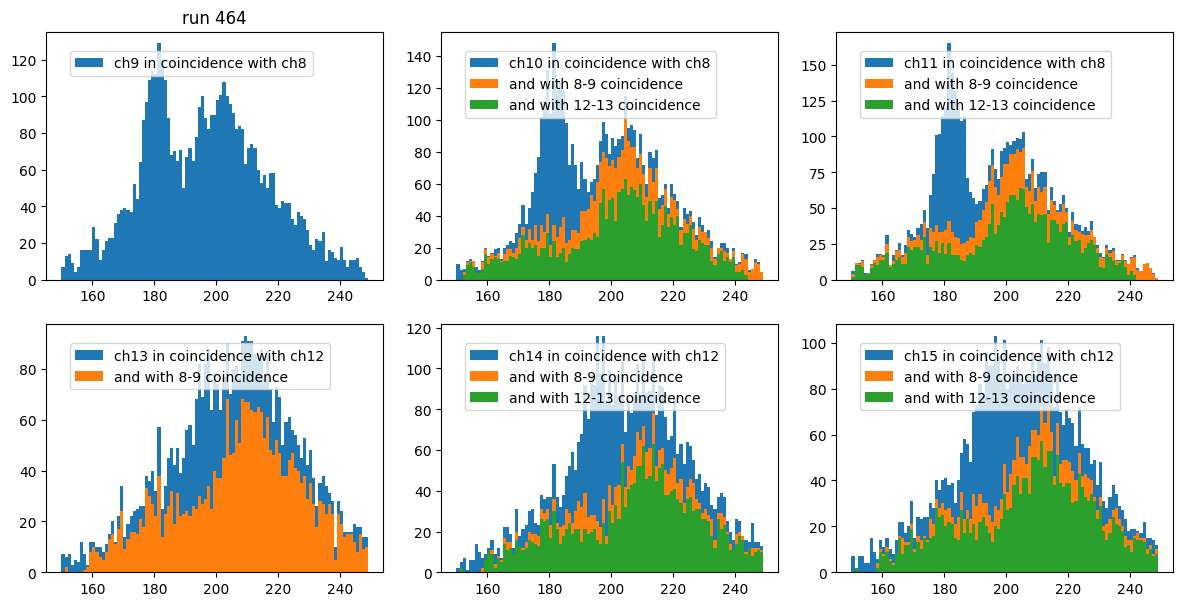

In [130]:
# Look at signal_time distributions when there is a tight coincidence with the first channel (2 sigma)

channels = range(8,16)

st_8 = []
st_9 = []
st_coin_89 = {}
st_coin_1213 = {}
diff_89 = []
ev_89 = []
ev_1213 = []

for st_range in [[20,60],[150,250]]:
    fig, axss = plt.subplots(2, 3, figsize=(12, 6))
    fig.tight_layout()

    axss[0][0].set_title("run " + str(run_number))

    for other_chan in range(3):
    #for it in range(2):
        for it in range(2):
            first_chan = it*4 + 8
        #for other_chan in range(3):
            axis = axss[it][other_chan]
            sts = []
            for ie, event in enumerate(signal_times[first_chan]):
                if len(event) > 0:
                    for first_chan_st in event:
                        if st_range[0] < first_chan_st < st_range[1]:
                            for other_st in signal_times[first_chan+other_chan+1][ie]:
                                if st_range[0] < other_st < st_range[1]:
                                    diff = first_chan_st - other_st
                                    n_sigma = abs(diff - delta_t_mean[first_chan][first_chan+other_chan+1])/delta_t_sigma[first_chan][first_chan+other_chan+1]
                                    if n_sigma < 2.:
                                        sts.append(other_st)
                                        if first_chan+other_chan+1 == 9 and st_range[0]>90:
                                            st_8.append(first_chan_st)
                                            st_9.append(other_st)
                                            diff_89.append(diff)
                                            ev_89.append(ie)
                                        if first_chan+other_chan+1 == 13 and st_range[0]>90:
                                            ev_1213.append(ie)
                                        for xtra in [10,11,13,14,15]:
                                            if first_chan+other_chan+1 == xtra and ie in ev_89:
                                                if xtra not in st_coin_89:
                                                    st_coin_89[xtra] = []
                                                st_coin_89[xtra].append(other_st)
                                        for xtra in [9,10,11,14,15]:
                                            if first_chan+other_chan+1 == xtra and ie in ev_1213 and ie in ev_89:
                                                if xtra not in st_coin_1213:
                                                    st_coin_1213[xtra] = []
                                                st_coin_1213[xtra].append(other_st)

            # fit to a Gaussian
            bin_width = 1
            bins = np.arange(st_range[0],st_range[1],bin_width)
            hist, bin_edges = np.histogram(sts, bins=bins)
            max_num = np.max(hist)
            low = -1
            high = -1
            for ib, num in enumerate(hist):
                if low < 0 and num > 0.3*max_num:
                    low = ib
                if low > 0 and num < 0.3*max_num and ib > low+10:
                    high = ib
                    break

            fit_hist = [hist[i] for i in range(low,high)]
            bin_centres = [bins[i]+bin_width/2. for i in range(low,high)]

            total = 0.
            sum = 0.
            sum2 = 0.
            for num,bc in zip(fit_hist, bin_centres):
                total+= num
                sum += num*bc
                sum2 += num*bc*bc
            mean = sum/total
            var = sum2/total - mean*mean
            std = np.sqrt(var)

            if st_range[0] == 20:
                # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                p0 = [total*bin_width, mean, std]

                coeff, var_matrix = curve_fit(gauss, bin_centres, fit_hist, p0=p0)

                # Get the fitted curve
                fine_bins = np.arange(bin_centres[0],bin_centres[-1],bin_width/10)
                hist_fit = gauss(fine_bins, *coeff)
            elif 1==2:
                p0 = [total*bin_width, mean, std, 100.]

                coeff, var_matrix = curve_fit(gauss_back, bin_centres, fit_hist, p0=p0)

                # Get the fitted curve
                fine_bins = np.arange(bin_centres[0],bin_centres[-1],bin_width/10)
                hist_fit = gauss_back(fine_bins, *coeff)

            foc1 = first_chan+other_chan+1
            axis.hist(sts,bins=bins,label='ch'+str(foc1)+' in coincidence with ch'+str(first_chan))
            if st_range[0] == 20:
                axis.plot(fine_bins,hist_fit,label=f"$\mu$={coeff[1]:.2f}, $\sigma$={coeff[2]:.2f}")
            if foc1 > 9 and st_range[0] != 20:
                axis.hist(st_coin_89[foc1],bins=bins,label=('and with 8-9 coincidence'))
                print(f"89 channel {foc1}, mean = {np.mean(st_coin_89[foc1]):.1f}, std = {np.std(st_coin_89[foc1]):.1f}  ")
            if foc1 in [9,10,11,14,15] and st_range[0] != 20 and foc1 in st_coin_1213:
                axis.hist(st_coin_1213[foc1],bins=bins,label=('and with 12-13 coincidence'))
                print(f"1213 channel {foc1}, mean = {np.mean(st_coin_1213[foc1]):.1f}, std = {np.std(st_coin_1213[foc1]):.1f}  ")
            axis.legend(loc='upper left', bbox_to_anchor=(0.05,0.95))
            #plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
    plt.show()

In [121]:
len(ev_1213)

0

In [90]:
ev_89[0:5]

[60, 110, 132, 143, 150]

In [35]:
# define event selections based on tight coincidence between two channels in same scintillator
# DOES NOT HELP! #

# require tight coincidence for lower time range (first bucket)
select_1 = {}
# require tight coincidence for higher time range (second bucket)
select_2 = {}

for st_range,select in zip([[0,100],[100,400]],[select_1,select_2]):
    for it in range(2):
        first_chan = it*4 + 8
        if first_chan not in select:
            select[first_chan] = {}
        for other_chan in range(3):
            if first_chan+other_chan+1 not in select[first_chan]:
                select[first_chan][first_chan+other_chan+1] = []
            for ie, event in enumerate(signal_times[first_chan]):
                selected = False
                if len(event) > 0:
                    for first_chan_st in event:
                        if st_range[0] < first_chan_st < st_range[1]:
                            for other_st in signal_times[first_chan+other_chan+1][ie]:
                                if st_range[0] < other_st < st_range[1]:
                                    diff = first_chan_st - other_st
                                    n_sigma = abs(diff - delta_t_mean[first_chan][first_chan+other_chan+1])/delta_t_sigma[first_chan][first_chan+other_chan+1]
                                    if n_sigma < 2.:
                                        selected = True
                if selected:
                    select[first_chan][first_chan+other_chan+1].append(ie)

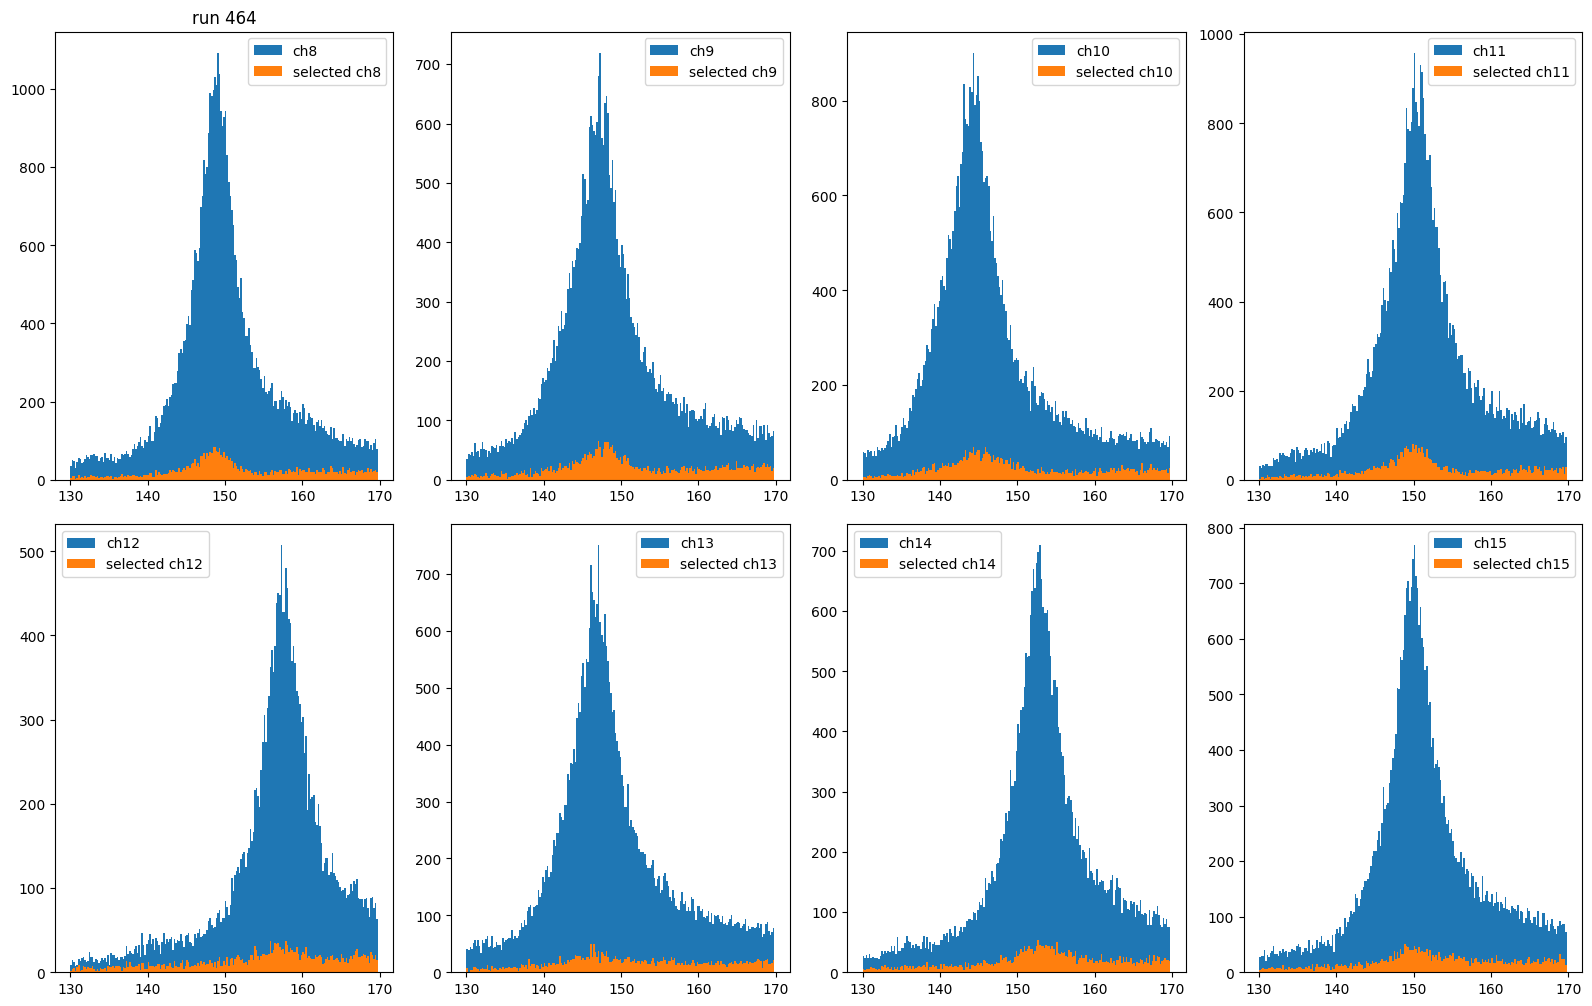

In [37]:
# Look at signal_time difference distributions for each scintillator channel

channels = range(8,16)
bins=np.arange(130,170,0.2)

fig, axss = plt.subplots(2, 4, figsize=(16, 10))
fig.tight_layout()

axss[0][0].set_title("run " + str(run_number))

for ic, c in enumerate(channels):
    axis = axss[int(ic/4)][ic%4]
    diffs = []
    diffs_select = []
    for ie,event in enumerate(signal_times[c]):
        if len(event) > 1:
            for j in range(1,len(event)):
                for i in range(0,j):
                    diff = event[j]-event[i]
                    if bins[0] < diff < bins[-1]:
                        diffs.append(diff)
                        select = False
                        if c == 8:
                            if ie in select_1[8][9] and ie in select_2[8][9]:
                                select = True
                        elif c in [9, 10, 11]:
                            if ie in select_1[8][c] and ie in select_2[8][c]:
                                select = True
                        elif c == 12:
                            if ie in select_1[12][13] and ie in select_2[12][13]:
                                select = True
                        elif c in [13, 14, 15]:
                            if ie in select_1[12][c] and ie in select_2[12][c]:
                                select = True
                        if select:
                            diffs_select.append(diff)

    #axis.hist(diffs,bins=np.arange(0,330,2),label='ch'+str(c))
    axis.hist(diffs,bins=bins,label='ch'+str(c))
    axis.hist(diffs_select,bins=bins,label='selected ch'+str(c))
    axis.legend()
#plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
plt.show()

event 37
8 39.60189746390251
8 187.48677546997897
10 39.37984647952825 i
10 187.882206430361 j


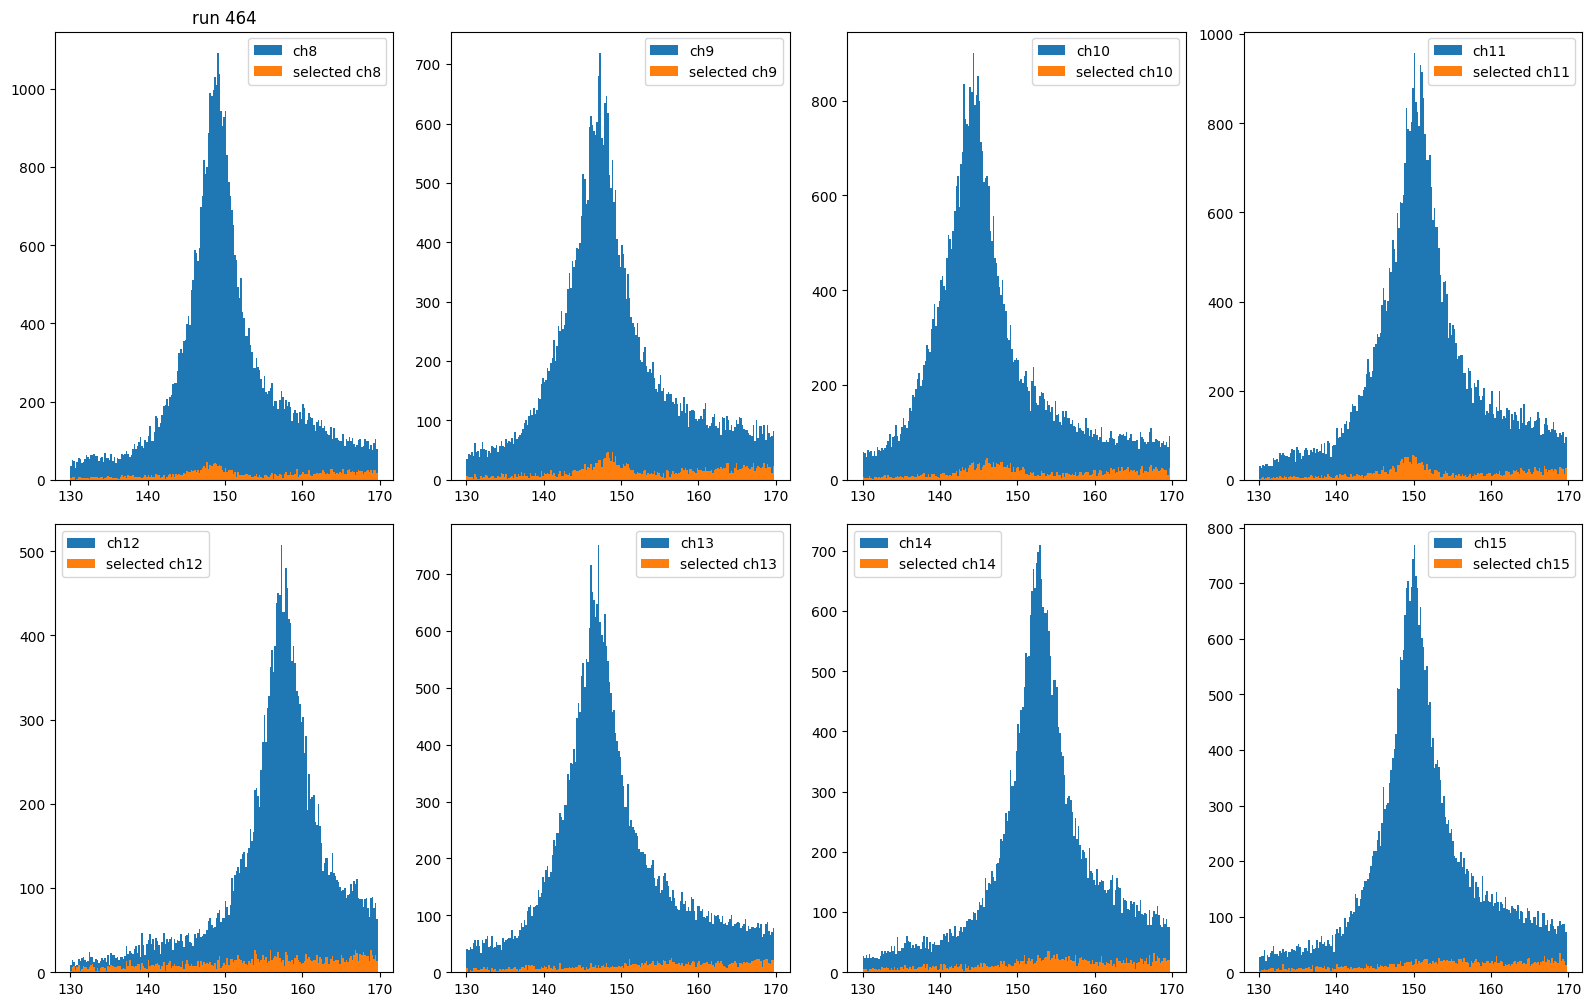

In [58]:
# Look at signal_time difference distributions for each scintillator channel
# Require that times used satisfy a tight coincidence with another channel in the same scintillator

coincidence = {
    8:9,
    9:8,
    10:8,
    11:8,
    12:13,
    13:12,
    14:12,
    15:12
}

channels = range(8,16)
bins=np.arange(130,170,0.2)

fig, axss = plt.subplots(2, 4, figsize=(16, 10))
fig.tight_layout()

axss[0][0].set_title("run " + str(run_number))

for ic, c in enumerate(channels):
    axis = axss[int(ic/4)][ic%4]
    diffs = []
    diffs_select = []
    ip = 0
    for ie,event in enumerate(signal_times[c]):
        if len(event) > 1:
            for j in range(1,len(event)):
                for i in range(0,j):
                    diff = event[j]-event[i]

                    #if c==10 and 144<diff<145:
                    if c==10 and ie in [37]:
                        ip+=1
                        if ip < 20:
                            print('event',ie)
                            for st in signal_times[8][ie]:
                                print(8,st)
                            for st in signal_times[10][ie]:
                                buf = ''
                                if st == event[j]:
                                    buf = 'j'
                                elif st == event[i]:
                                    buf = 'i'
                                print(10,st,buf)


                    if bins[0] < diff < bins[-1]:
                        diffs.append(diff)
                        coin_ch = coincidence[c]
                        order = 1
                        first_chan = coin_ch
                        o_chan = c
                        if coin_ch > c:
                            order = -1
                            first_chan = c
                            o_chan = coin_ch
                        select_i = False
                        for coin_st in signal_times[coin_ch][ie]:
                            delta = (coin_st - event[i])*order
                            n_sigma = abs(delta - delta_t_mean[first_chan][o_chan])/delta_t_sigma[first_chan][o_chan]
                            if n_sigma < 2.:
                                select_i = True
                        select_j = False
                        for coin_st in signal_times[coin_ch][ie]:
                            delta = (coin_st - event[j])*order
                            n_sigma = abs(delta - delta_t_mean[first_chan][o_chan])/delta_t_sigma[first_chan][o_chan]
                            if n_sigma < 2.:
                                select_j = True
                        if select_j:
                            diffs_select.append(diff)

    #axis.hist(diffs,bins=np.arange(0,330,2),label='ch'+str(c))
    axis.hist(diffs,bins=bins,label='ch'+str(c))
    axis.hist(diffs_select,bins=bins,label='selected ch'+str(c))
    axis.legend()
#plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
plt.show()

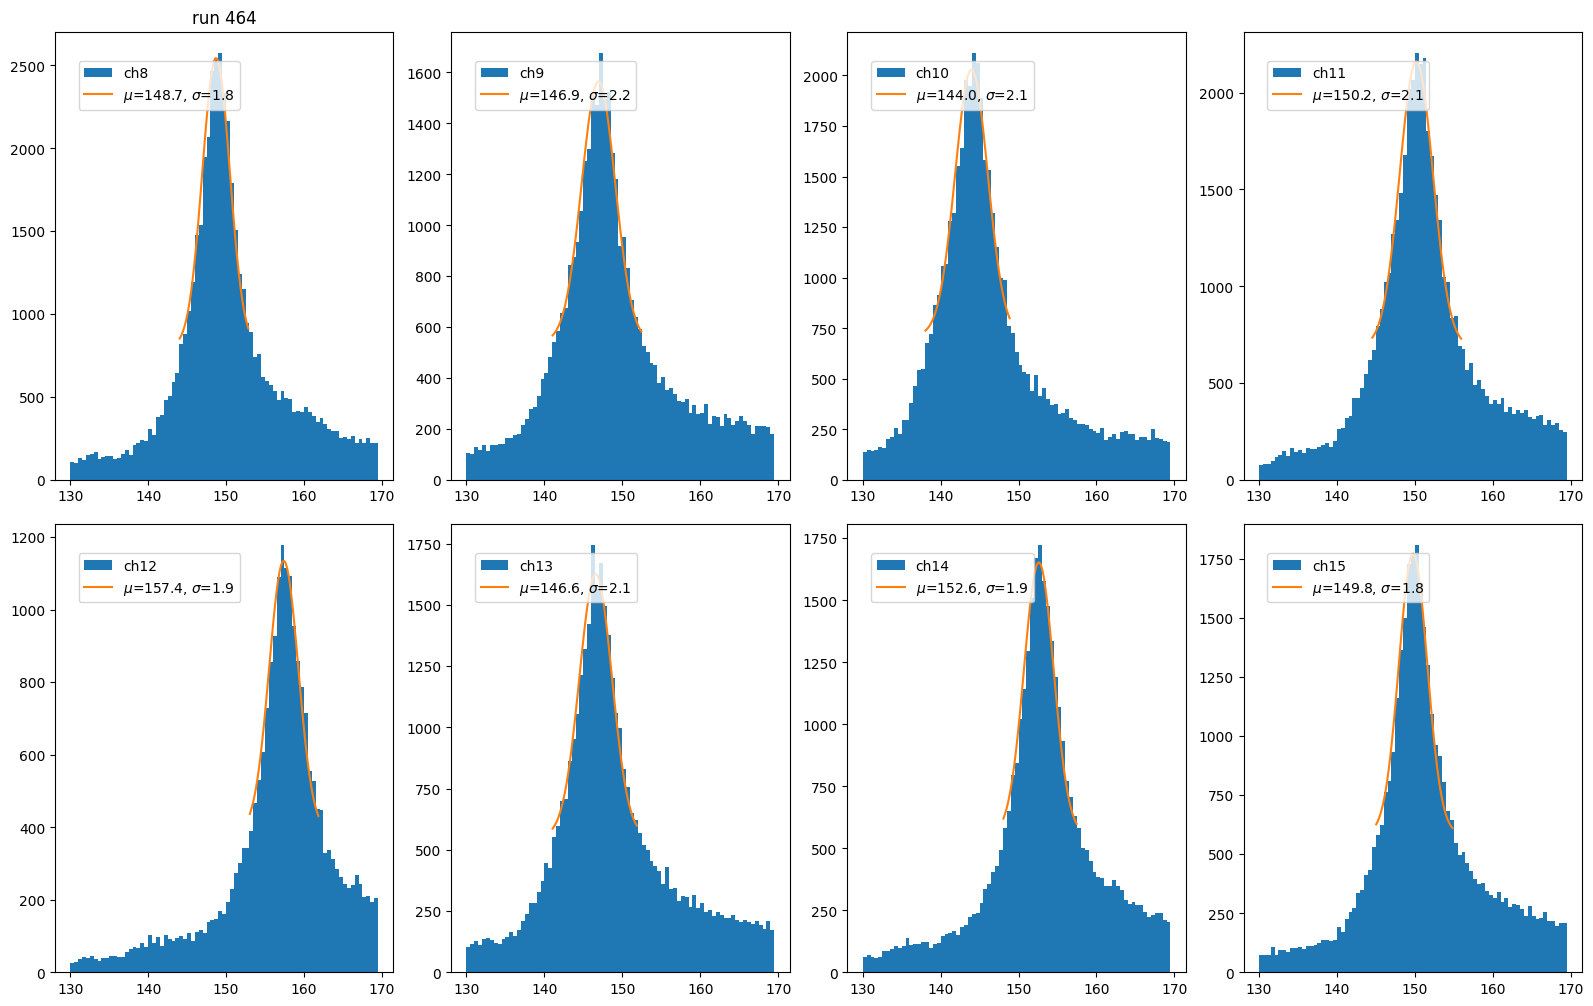

In [63]:
# Look at signal_time difference distributions for each scintillator channel

channels = range(8,16)
bins=np.arange(130,170,0.5)

fig, axss = plt.subplots(2, 4, figsize=(16, 10))
fig.tight_layout()

axss[0][0].set_title("run " + str(run_number))

for ic, c in enumerate(channels):
    axis = axss[int(ic/4)][ic%4]
    diffs = []
    diffs_select = []
    for ie,event in enumerate(signal_times[c]):
        if len(event) > 1:
            for j in range(1,len(event)):
                for i in range(0,j):
                    diff = event[j]-event[i]
                    if bins[0] < diff < bins[-1]:
                        diffs.append(diff)

    # fit to a Gaussian
    hist, bin_edges = np.histogram(diffs, bins=bins)
    max_num = np.max(hist)
    low = -1
    high = -1
    for ib, num in enumerate(hist):
        if low < 0 and num > 0.3*max_num:
            low = ib
        if low > 0 and num < 0.3*max_num:
            high = ib
            break

    fit_hist = [hist[i] for i in range(low,high)]
    bin_centres = [bins[i]+0.05 for i in range(low,high)]

    total = 0.
    sum = 0.
    sum2 = 0.
    for num,bc in zip(fit_hist, bin_centres):
        total+= num
        sum += num*bc
        sum2 += num*bc*bc
    mean = sum/total
    var = sum2/total - mean*mean
    std = np.sqrt(var)

    p0 = [total*0.1, mean, std, 100.]

    coeff, var_matrix = curve_fit(gauss_back, bin_centres, fit_hist, p0=p0)

    # Get the fitted curve
    fine_bins = np.arange(bin_centres[0],bin_centres[-1],0.2)
    hist_fit = gauss_back(fine_bins, *coeff)

    #axis.hist(diffs,bins=np.arange(0,330,2),label='ch'+str(c))
    axis.hist(diffs,bins=bins,label='ch'+str(c))
    axis.plot(fine_bins,hist_fit,label=f"$\mu$={coeff[1]:.1f}, $\sigma$={coeff[2]:.1f}")
    axis.legend(loc='upper left', bbox_to_anchor=(0.05,0.95))
#plt.savefig(folder+'waveforms_'+str(run_number)+'_'+chan_set+'.png')
plt.show()